In [50]:
'''Imports'''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
load_path = "./Cleaned Data/Historical/"

In [3]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

## Seasonal Soil Moisture Data

In [4]:
'''Load Data'''
soilMoist = pd.read_csv(load_path + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

In [5]:
soilMoist.head()

,DATE,LOCATION,d.15,d.46,d.76,d.107,d.137,d.168,d.198,d.229,d.259,d.290,d.320
0,1966-09-14,S1S,NaN,3.81,2.13,2.67,2.44,2.74,2.44,2.74,10.36,11.51,11.05
1,1966-09-14,S2W,NaN,3.05,2.97,2.97,2.74,2.90,3.51,3.81,3.12,1.45,2.90
2,1966-09-14,S3E,NaN,1.52,0.91,2.67,3.81,1.37,2.97,1.83,1.52,0.46,NaN
3,1966-09-14,S3W,NaN,1.37,0.91,2.51,4.11,4.27,3.20,4.88,3.43,6.25,5.79
4,1966-09-14,S4S,NaN,1.75,1.68,2.97,3.28,3.96,2.74,3.51,2.67,2.59,NaN


In [6]:
'''Data Cleaning'''
#Refine to S2 and S6 measurements
sites = ['S2E', 'S2S','S6N', 'S6S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)]

    #test if bulktemp is more than one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

soilMoist_melt['PAW'] = PAW

In [7]:
soilMoist_melt.head()

,DATE,LOCATION,DEPTH,VWC,PAW
0,1967-10-31,S2E,d.15,0.81,0.000000
1,1967-11-02,S6N,d.15,1.32,0.000000
2,1968-03-11,S2E,d.15,3.84,0.000000
3,1968-03-11,S6N,d.15,6.15,0.327260
4,1968-04-30,S2E,d.15,5.23,0.037052


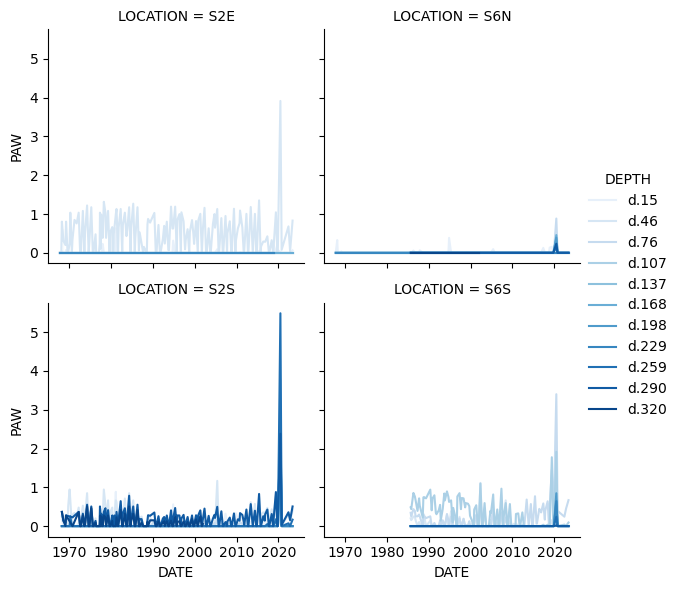

In [8]:
'''Plots'''
sns.relplot(data = soilMoist_melt, x = 'DATE', y = 'PAW',
            hue = 'DEPTH', palette = 'Blues',
            col = 'LOCATION', col_wrap = 2,
            kind = 'line', 
            height = 3)

## 10 Minute Soil Moisture Data

Snow Data to sort by seasonality

In [9]:
snowHist = pd.read_csv(load_path + 'MEF_snowSWE_biweekly.csv', 
                parse_dates = ['Date'])

#Segment out S2 data
snowHist_S2 = snowHist[snowHist.Watershed == 'S2'].reset_index(drop = True)

#Group by snow course and find max annual SWE
snowHist_S2['Year'] = snowHist_S2.Date.dt.year
snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

snowHist_S2_grouped.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_18688\559406229.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,SnowcourseID,Year,SnowDEPTH,SWE
0,S21,1962,55.0,12.0
1,S21,1963,50.0,9.0
2,S21,1964,43.0,8.0
3,S21,1965,67.0,17.0
4,S21,1966,60.0,19.0


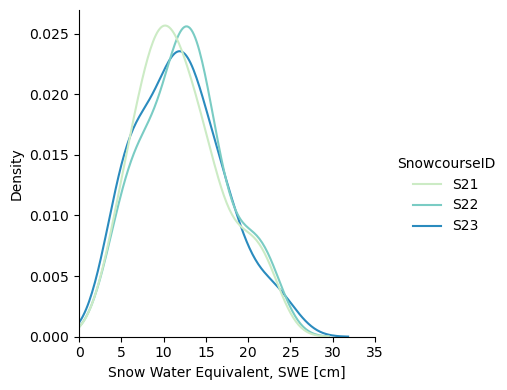

In [10]:
#S21 - South Upland, S22 - Bog, S23 - North Upland
g = sns.displot(snowHist_S2_grouped, x="SWE", hue="SnowcourseID", kind = 'kde', 
            height = 4, 
            palette = 'GnBu')
g.set(xlim = (0, 35))
g.set_axis_labels("Snow Water Equivalent, SWE [cm]", "Density")
plt.show()

In [11]:
#Group further by only year
snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

#Separate years into quantiles
snowHist_S2_grouped_all['Quants'] = pd.cut(snowHist_S2_grouped_all.SWE, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
snowHist_S2_grouped_all.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_18688\3586161511.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,Year,SnowDEPTH,SWE,Quants
0,1962,55.0,12.0,MedSno
1,1963,51.0,9.0,LoSno
2,1964,45.0,8.0,LoSno
3,1965,71.0,17.0,MedSno
4,1966,71.0,22.0,HighSno


Streamflow

In [12]:
streamHist = pd.read_csv(load_path + 'S2_Breakpoint_streamflow.csv', 
                parse_dates = ['DateTime'])

#groupby date and average across timestamps
streamHist['Year'] = streamHist.DateTime.dt.year
streamHist['Month'] = streamHist.DateTime.dt.month
streamHist['DOY'] = streamHist.DateTime.dt.dayofyear
streamHist_daily = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'q.interval'].mean().reset_index(drop = False)

streamHist_daily

C:\Users\jone3247\AppData\Local\Temp\ipykernel_18688\40953630.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  streamHist_daily = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'q.interval'].mean().reset_index(drop = False)


,DOY,Year,Stage.ft,Q.cfs,q.mmh,q.interval
0,1,1963,0.00000,0.000000,0.000000,0.000000
1,1,1964,0.00000,0.000000,0.000000,0.000000
2,1,1965,0.00000,0.000000,0.000000,0.000000
3,1,1966,0.05100,0.003030,0.003180,0.002547
4,1,1967,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
20058,366,2000,0.00000,0.000000,0.000000,0.000000
20059,366,2004,0.00000,0.000000,0.000000,0.000000
20060,366,2008,0.00000,0.000000,0.000000,0.000000
20061,366,2012,0.00000,0.000000,0.000000,0.000000


Soil Moisture

In [41]:
soilMoist_10min = pd.read_csv(load_path + 'MEF_S2_soil_moisture_10min.csv', 
                              parse_dates = ['TIMESTAMP'])

soilMoist_10min['YEAR'] = soilMoist_10min.TIMESTAMP.dt.year
soilMoist_10min['MONTH'] = soilMoist_10min.TIMESTAMP.dt.month
soilMoist_10min['DOY'] = soilMoist_10min.TIMESTAMP.dt.dayofyear

#Only pull out full years
soilMoist_10min = soilMoist_10min[(soilMoist_10min.YEAR > 2008) & (soilMoist_10min.YEAR < 2023)]

#Aggregate to daily values
soilMoist_daily = soilMoist_10min.groupby(['YEAR', 'DOY', 'MONTH'])['S2S_UP_SH', 'S2S_UP_DP', 'S2S_MI_SH', 'S2S_MI_DP', 'S2S_LO_SH', 'S2S_LO_DP', 'S2N_UP_SH', 'S2N_UP_DP', 'S2N_MI_SH', 'S2N_MI_DP', 'S2N_LO_SH', 'S2N_LO_DP'].mean().reset_index()

#Merge with snow data
soilMoist_snow = pd.merge(soilMoist_daily, snowHist_S2_grouped_all[snowHist_S2_grouped_all.Year > 2007], left_on = 'YEAR', right_on = 'Year', how = 'outer')
soilMoist_snow = soilMoist_snow.drop('Year', axis = 1)
soilMoist_snow.head()

C:\Users\jone3247\AppData\Local\Temp\ipykernel_18688\4233756797.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soilMoist_daily = soilMoist_10min.groupby(['YEAR', 'DOY', 'MONTH'])['S2S_UP_SH', 'S2S_UP_DP', 'S2S_MI_SH', 'S2S_MI_DP', 'S2S_LO_SH', 'S2S_LO_DP', 'S2N_UP_SH', 'S2N_UP_DP', 'S2N_MI_SH', 'S2N_MI_DP', 'S2N_LO_SH', 'S2N_LO_DP'].mean().reset_index()


,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP,SnowDEPTH,SWE,Quants
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,48.0,13.0,MedSno
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,48.0,13.0,MedSno
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,48.0,13.0,MedSno
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,NaN,NaN,NaN,NaN,NaN,48.0,13.0,MedSno
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,NaN,NaN,NaN,NaN,NaN,48.0,13.0,MedSno


In [42]:
all_water = pd.merge(soilMoist_snow, streamHist_daily[streamHist_daily.Year > 2007], left_on = ['YEAR', 'DOY'], right_on = ['Year', 'DOY'], 
                     how = 'outer')
all_water = all_water.drop('Year', axis = 1)
all_water.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP,SnowDEPTH,SWE,Quants,Stage.ft,Q.cfs,q.mmh,q.interval
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,NaN,NaN,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,NaN,NaN,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,NaN,NaN,NaN,48.0,13.0,MedSno,0.0,0.0,0.0,0.0


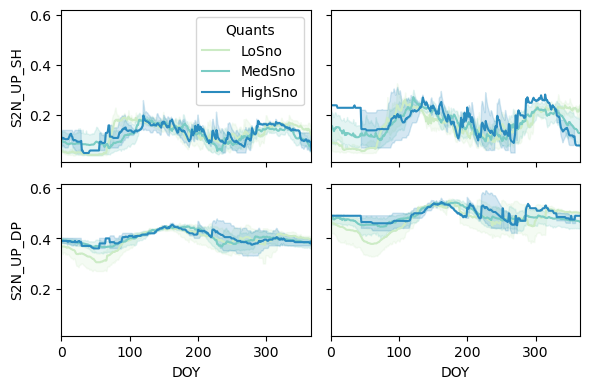

In [43]:
#Just soil moisture plot by area
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (6, 4), 
                                             layout = 'tight',
                                             sharey = True, 
                                             sharex = True)

sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2N_UP_SH", hue = "Quants", palette = 'GnBu',  ax = ax1)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2N_UP_DP", hue = "Quants", palette = 'GnBu', ax = ax3, legend = False)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2S_UP_SH", hue = "Quants", palette = 'GnBu', ax = ax2, legend = False)
sns.lineplot(data = soilMoist_snow, x = "DOY", y = "S2S_UP_DP", hue = "Quants", palette = 'GnBu', ax = ax4, legend = False)

ax1.set_xlim(0, 365)

plt.show()

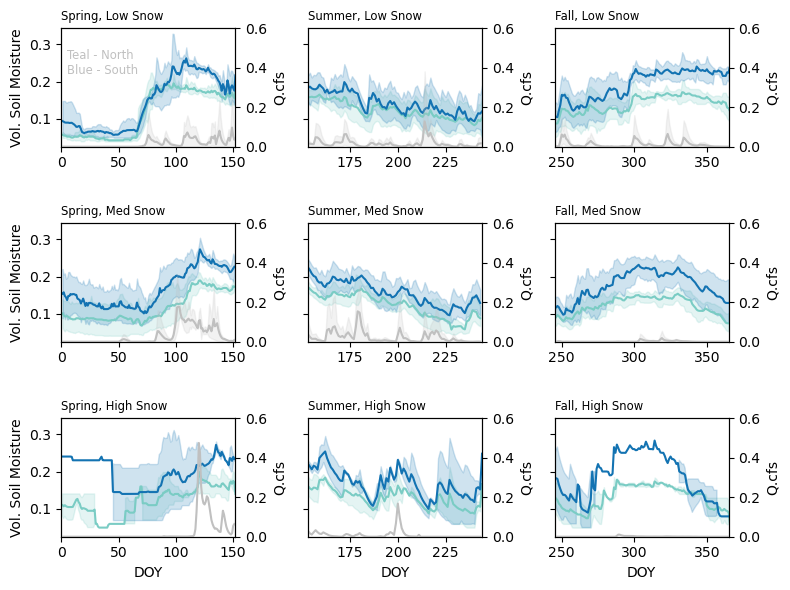

In [44]:
#Soil moisture and streamflow by snow year and season
def plot_SM_Q(ax_i, ax_j, soilM):
    #find season based on ax column index
    if(ax_i == 0): #spring
        soiltemp = soilM[soilM.MONTH < 6]
        axs[ax_j, ax_i].set_xlim(0, 152)
        axs[ax_j, ax_i].set_ylabel('Vol. Soil Moisture')
    elif(ax_i == 1): #summer
        soiltemp = soilM[(soilM.MONTH > 5) & (soilM.MONTH < 9)]
        axs[ax_j, ax_i].set_xlim(153, 244)
    else: #fall
        soiltemp = soilM[soilM.MONTH > 8]
        axs[ax_j, ax_i].set_xlim(245, 365)

    #find snow year based on ax row index
    if(ax_j == 0): #low snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'LoSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    elif(ax_j == 1): #med snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'MedSno']
        axs[ax_j, ax_i].set_xlabel(' ')
    else: #high snow
        soiltemp_f = soiltemp[soiltemp.Quants == 'HighSno']

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2N_UP_SH', ax = axs[ax_j, ax_i], color = pal[2])
    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'S2S_UP_SH', ax = axs[ax_j, ax_i], color = pal[4])

    ax2 = axs[ax_j, ax_i].twinx()

    sns.lineplot(data = soiltemp_f, x = 'DOY', y = 'Q.cfs', 
                 color = 'silver', zorder = -2, 
                 ax = ax2)
    ax2.set_ylim(0, 0.6)

    season_labels = ['Spring', 'Summer', 'Fall']
    snow_labels = ['Low Snow', 'Med Snow', 'High Snow']

    axs[ax_j, ax_i].set_title(season_labels[ax_i] + ', ' + snow_labels[ax_j], loc = 'left', fontsize = 'small')

fig, axs = plt.subplots(3, 3, figsize = (8, 6), 
    sharey = True, 
    layout = 'tight')

for i in range(0, 3):
    for j in range(0, 3):
        plot_SM_Q(i, j, all_water)

axs[0, 0].text(5, 0.22, 'Teal - North\nBlue - South', color = 'silver', fontsize = 'small')
plt.savefig('../Figures/HistoricalFigs/SoilMoist_Timeseries.pdf')
plt.show()


## Water Balance Analysis

In [45]:
#Import Precipitation
precip = pd.read_csv(load_path + 'MEF_precipitation_daily.csv', 
                    parse_dates = ['DATE'])
precip['YEAR'] = precip.DATE.dt.year
precip['DOY'] = precip.DATE.dt.dayofyear
precip.head()

,DATE,NADP_PCP,South_PCP,North_PCP,NADP_Flag,South_Flag,North_Flag,YEAR,DOY
0,1961-01-01,NaN,0.13,NaN,NaN,NaN,NaN,1961,1
1,1961-01-02,NaN,0.00,NaN,NaN,NaN,NaN,1961,2
2,1961-01-03,NaN,0.00,NaN,NaN,NaN,NaN,1961,3
3,1961-01-04,NaN,0.64,NaN,NaN,NaN,NaN,1961,4
4,1961-01-05,NaN,0.00,NaN,NaN,NaN,NaN,1961,5


In [65]:
#Merge with soil moisture and snow data

all_water = pd.merge(all_water, precip[precip.YEAR > 2007], on = ['YEAR', 'DOY'])
all_water['Season'] = ['Spring' if i < 6 else ('Fall' if i > 8 else 'Summer') for i in all_water.MONTH]
all_water.head()

,YEAR,DOY,MONTH,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,...,South_Flag_x,North_Flag_x,Season,DATE_y,NADP_PCP_y,South_PCP_y,North_PCP_y,NADP_Flag_y,South_Flag_y,North_Flag_y
0,2009.0,1.0,1.0,0.07,0.43,0.07,0.497847,0.110000,0.18,NaN,...,NaN,NaN,Spring,2009-01-01,NaN,0.10,0.15,NaN,NaN,NaN
1,2009.0,2.0,1.0,0.07,0.43,0.07,0.492361,0.110000,0.18,NaN,...,NaN,NaN,Spring,2009-01-02,NaN,0.00,0.00,NaN,NaN,NaN
2,2009.0,3.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,Spring,2009-01-03,NaN,1.70,1.78,NaN,NaN,NaN
3,2009.0,4.0,1.0,0.07,0.43,0.07,0.490000,0.110000,0.18,NaN,...,NaN,NaN,Spring,2009-01-04,NaN,0.08,0.05,NaN,NaN,NaN
4,2009.0,5.0,1.0,0.07,0.43,0.07,0.490000,0.111875,0.18,NaN,...,NaN,NaN,Spring,2009-01-05,NaN,0.00,0.00,NaN,NaN,NaN


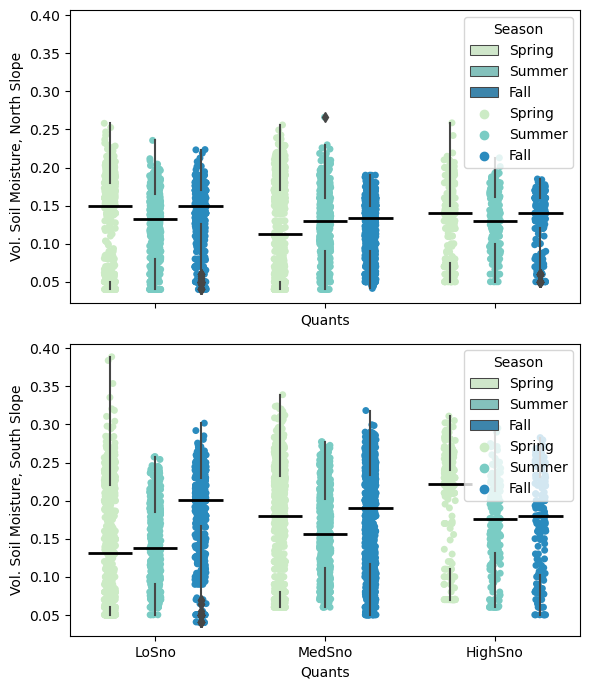

In [77]:
fig, [ax, ax2] = plt.subplots(2, 1, figsize = (6, 7), 
                       sharex = True, 
                       sharey = True, 
                       layout = 'tight')

sns.boxplot(data = all_water, x = 'Quants', y = 'S2N_UP_SH', hue = 'Season',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax, zorder = 1)
sns.stripplot(data = all_water, x = 'Quants', y = 'S2N_UP_SH', hue = 'Season', dodge = True, 
              palette = 'GnBu',
              ax = ax, zorder = 0)

ax.set_ylabel('Vol. Soil Moisture, North Slope')

sns.boxplot(data = all_water, x = 'Quants', y = 'S2S_UP_SH', hue = 'Season',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            palette = 'GnBu',
            ax = ax2, zorder = 1)
sns.stripplot(data = all_water, x = 'Quants', y = 'S2S_UP_SH', hue = 'Season', dodge = True, 
              palette = 'GnBu',
              ax = ax2, zorder = 0)

ax2.set_ylabel('Vol. Soil Moisture, South Slope')
plt.show()

In [71]:
#Statistical Analysis
LoSno_Spring = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S_UP_SH'])
LoSno_Summer = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S_UP_SH'])
LoSno_Fall = all_water[(all_water.Quants == 'LoSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S_UP_SH'])

MedSno_Spring = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S_UP_SH'])
MedSno_Summer = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S_UP_SH'])
MedSno_Fall = all_water[(all_water.Quants == 'MedSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S_UP_SH'])

HighSno_Spring = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Spring')].dropna(subset = ['S2S_UP_SH'])
HighSno_Summer = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Summer')].dropna(subset = ['S2S_UP_SH'])
HighSno_Fall = all_water[(all_water.Quants == 'HighSno') & (all_water.Season == 'Fall')].dropna(subset = ['S2S_UP_SH'])

soilM_ANOVA = scipy.stats.f_oneway(LoSno_Spring.S2S_UP_SH, LoSno_Summer.S2S_UP_SH, LoSno_Fall.S2S_UP_SH,
                                   MedSno_Spring.S2S_UP_SH, MedSno_Summer.S2S_UP_SH, MedSno_Fall.S2S_UP_SH, 
                                   HighSno_Spring.S2S_UP_SH, HighSno_Summer.S2S_UP_SH, HighSno_Fall.S2S_UP_SH)

print(soilM_ANOVA)

soilM_Tukey = scipy.stats.tukey_hsd(LoSno_Spring.S2S_UP_SH, LoSno_Summer.S2S_UP_SH, LoSno_Fall.S2S_UP_SH,
                                   MedSno_Spring.S2S_UP_SH, MedSno_Summer.S2S_UP_SH, MedSno_Fall.S2S_UP_SH, 
                                   HighSno_Spring.S2S_UP_SH, HighSno_Summer.S2S_UP_SH, HighSno_Fall.S2S_UP_SH)

print(soilM_Tukey)

F_onewayResult(statistic=36.76290380867223, pvalue=4.7230601963078984e-57)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.000     1.000    -0.013     0.013
 (0 - 2)     -0.049     0.000    -0.061    -0.037
 (0 - 3)     -0.027     0.000    -0.037    -0.016
 (0 - 4)     -0.017     0.000    -0.028    -0.005
 (0 - 5)     -0.034     0.000    -0.045    -0.024
 (0 - 6)     -0.052     0.000    -0.067    -0.037
 (0 - 7)     -0.028     0.000    -0.046    -0.011
 (0 - 8)     -0.029     0.000    -0.047    -0.012
 (1 - 0)     -0.000     1.000    -0.013     0.013
 (1 - 2)     -0.049     0.000    -0.063    -0.036
 (1 - 3)     -0.027     0.000    -0.039    -0.015
 (1 - 4)     -0.017     0.002    -0.030    -0.004
 (1 - 5)     -0.035     0.000    -0.047    -0.022
 (1 - 6)     -0.052     0.000    -0.069    -0.036
 (1 - 7)     -0.028     0.000    -0.047    -0.010
 (1 - 8)     -0.030     0.000    -0.048    -0.011
 (2 - 0

In [49]:
#Sort precip for seasonal analysis
precip_grouped = all_water.groupby(['YEAR', 'Season', 'SWE', 'Quants'], observed = True)['South_PCP'].sum().reset_index()
precip_grouped['SWE'] = np.where(precip_grouped.Season == 'Spring', precip_grouped.SWE, np.nan)
#precip_grouped_melted = pd.melt(precip_grouped, id_vars = ['YEAR', 'Season', 'Quants'], value_vars = ['SWE', 'South_PCP'], 
#                                var_name = 'Variable', value_name = 'Depth_cm')
precip_grouped.head()

,YEAR,Season,SWE,Quants,South_PCP
0,2009.0,Fall,NaN,MedSno,18.46
1,2009.0,Spring,13.0,MedSno,27.29
2,2009.0,Summer,NaN,MedSno,23.69
3,2010.0,Fall,NaN,LoSno,28.87
4,2010.0,Spring,7.0,LoSno,14.61


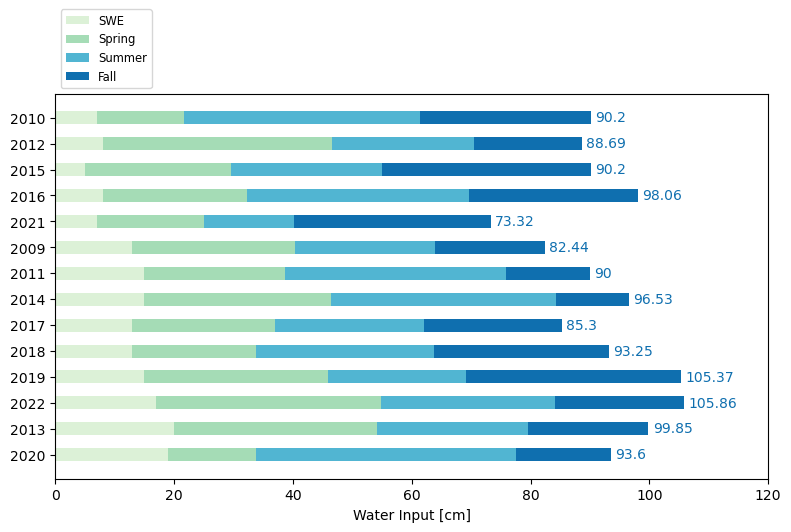

In [ ]:
#Net Water Input Diagram - Hand done kill me now
category_names = ['SWE', 'Spring', 'Summer', 'Fall']
results = {
    #Lo Snow years
    '2010': [7, 14.61, 39.72, 28.87],
    '2012': [8, 38.53, 23.92, 18.24],
    '2015': [5, 24.66, 25.41, 35.13],
    '2016': [8, 24.21, 37.44, 28.41],
    '2021': [7, 18.09, 15.13, 33.1],
    #Med Snow years
    '2009': [13, 27.29, 23.69, 18.46],
    '2011': [15, 23.71, 37.24, 14.05],
    '2014': [15, 31.34, 37.91, 12.28], 
    '2017': [13, 23.99, 25.06, 23.25],
    '2018': [13, 20.81, 30, 29.44],
    '2019': [15, 30.87, 23.25, 36.25],
    '2022': [17, 37.83, 29.26, 21.77],
    #High Snow years
    '2013': [20, 34.12, 25.43, 20.3],
    '2020': [19, 14.74, 43.85, 16.01]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['GnBu'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        if(i == 3):
            ax.bar_label(rects, color=color, padding = 3)
    
    ax.legend(bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    ax.set_xlim(0, 120)
    ax.set_xlabel('Water Input [cm]')

    return fig, ax


survey(results, category_names)
plt.savefig('../Figures/HistoricalFigs/NetWaterInput.pdf', bbox_inches = 'tight')
plt.show()